In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


data = pd.read_csv('France_spc.csv')
data = data.drop(columns=['Unnamed: 0'])

target = pd.read_csv('France_lab.csv')
target = target['SOC']

# Extract features and target
X = data.values
y = target.values

# Apply Savitzky-Golay smoothing filter
def apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2):
    smoothed_X = savgol_filter(X, window_length=window_length, polyorder=polyorder, deriv=deriv, delta=delta, axis=0)
    return smoothed_X

# Apply Standard Normal Variate (SNV) transformation
def standard_normal_variate(X):
    snv_X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
    return snv_X

# Optionally apply Savitzky-Golay filter and SNV transformation
X_sg = apply_savitzky_golay(X, window_length=11, polyorder=2, deriv=0, delta=2)
X_snv = standard_normal_variate(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_snv)

# Kennard-Stone Algorithm for Representative Sampling
def kennard_stone(X, n_samples):
    """Kennard-Stone algorithm to select a representative subset of samples."""
    n = X.shape[0]
    selected = np.zeros(n_samples, dtype=int)
    
    # Start with the two most distant samples
    dist_matrix = pairwise_distances(X)
    selected[0] = np.argmax(np.sum(dist_matrix, axis=1))
    selected[1] = np.argmax(dist_matrix[selected[0]])
    
    for i in range(2, n_samples):
        remaining = np.setdiff1d(np.arange(n), selected[:i])
        dist_to_selected = dist_matrix[remaining][:, selected[:i]]
        min_dist = np.min(dist_to_selected, axis=1)
        selected[i] = remaining[np.argmax(min_dist)]
    
    return selected

# Split data into calibration (80%) and test (20%) sets using random sampling
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X, y, test_size=0.3, random_state=42)

# Split data into calibration (80%) and test (20%) sets using Kennard-Stone sampling
n_cal = int(0.7 * X.shape[0])
ks_indices = kennard_stone(X, n_cal)
X_train_ks = X[ks_indices]
y_train_ks = y[ks_indices]
X_test_ks = np.delete(X, ks_indices, axis=0)
y_test_ks = np.delete(y, ks_indices, axis=0)

Epoch [10/2000], Loss: 1488.0360
Epoch [20/2000], Loss: 1293.6155
Epoch [30/2000], Loss: 1058.6107
Epoch [40/2000], Loss: 947.3561
Epoch [50/2000], Loss: 875.6884
Epoch [60/2000], Loss: 824.2283
Epoch [70/2000], Loss: 786.8114
Epoch [80/2000], Loss: 760.1180
Epoch [90/2000], Loss: 741.4608
Epoch [100/2000], Loss: 728.7065
Epoch [110/2000], Loss: 720.1973
Epoch [120/2000], Loss: 714.6672
Epoch [130/2000], Loss: 711.1614
Epoch [140/2000], Loss: 708.8615
Epoch [150/2000], Loss: 707.0580
Epoch [160/2000], Loss: 703.8963
Epoch [170/2000], Loss: 701.8253
Epoch [180/2000], Loss: 698.5856
Epoch [190/2000], Loss: 691.0637
Epoch [200/2000], Loss: 679.9240
Epoch [210/2000], Loss: 665.5198
Epoch [220/2000], Loss: 632.2111
Epoch [230/2000], Loss: 592.2126
Epoch [240/2000], Loss: 567.9731
Epoch [250/2000], Loss: 547.7316
Epoch [260/2000], Loss: 529.3547
Epoch [270/2000], Loss: 512.6785
Epoch [280/2000], Loss: 497.9656
Epoch [290/2000], Loss: 484.3519
Epoch [300/2000], Loss: 471.7287
Epoch [310/2000]

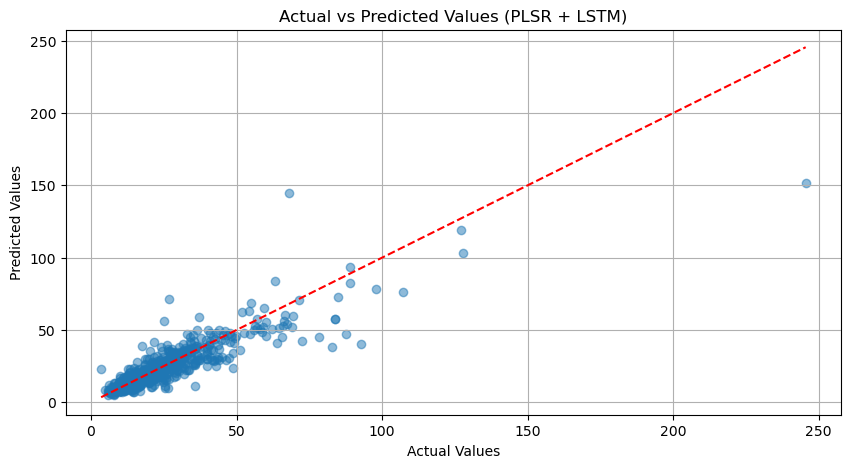

In [34]:



X_train = X_train_ks
X_test = X_test_ks
y_train = y_train_ks
y_test = y_test_ks




# Define the PLS Regression model for dimensionality reduction
n_components = min(41, X_train.shape[1])  # Adjust based on your data; 10 is an example
pls = PLSRegression(n_components=n_components)

# Fit PLSR on the training data and transform both training and test sets
#X_train_pls = pls.fit_transform(X_train, y_train)[0]
#X_test_pls = pls.transform(X_test)# check using traning data


# Fit PLSR on the training data and transform the training set
X_train_pls, _ = pls.fit_transform(X_train, y_train)

# Transform the test set using the fitted model (trained on the training set)
X_test_pls = pls.transform(X_test)


#pls  scores loading regression coeffieicent latent  variables , 

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pls, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pls, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # Select the last time step
        out = out[:, -1, :]
        # Forward pass through fully connected layer
        out = self.fc(out)
        return out

# Hyperparameters
input_size = X_train_pls.shape[1]  # Number of features after PLSR
hidden_size = 256
output_size = 1  # For regression
num_layers = 5
num_epochs = 2000
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train_tensor.unsqueeze(1))  # Add sequence dimension
    loss = criterion(outputs.squeeze(), y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    # Make predictions on the test set
    predictions = model(X_test_tensor.unsqueeze(1)).squeeze()
    
    # Calculate test loss
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Convert predictions and y_test to numpy arrays
    y_pred_np = predictions.numpy()
    y_test_np = y_test_tensor.numpy()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    
    # Calculate correlation coefficient
    correlation, _ = pearsonr(y_test_np, y_pred_np)
    print(f'Correlation coefficient: {correlation:.4f}')
    
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_np, y_pred_np, alpha=0.5)
    plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--')  # Perfect prediction line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values (PLSR + LSTM)')
    plt.grid(True)
    plt.show()

In [35]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Calculate R²
r2 = r2_score(y_test_np, y_pred_np)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))

# Calculate Bias
bias = np.mean(y_pred_np - y_test_np)

# Calculate RPD
std_dev_y = np.std(y_test_np)  # Standard deviation of actual values
rpd = std_dev_y / rmse

# Print results
print(f'R²: {r2:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Bias: {bias:.4f}')
print(f'Ratio of Performance to Deviation (RPD): {rpd:.4f}')


R²: 0.7913
Root Mean Squared Error (RMSE): 7.8230
Bias: -0.8850
Ratio of Performance to Deviation (RPD): 2.1888
